In [37]:
#load packages
#%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


from skimage.io import imread, imshow

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.losses import SparseCategoricalCrossentropy


import matplotlib.pyplot as plt
import seaborn as sns

import glob

from ipynb.fs.defs.CNN import check_grey_imgs, transform_image

In [2]:
#path to data

TRAIN_LABELS_PATH = './data/street-view-getting-started-with-julia/TrainLabelsExtended.csv'
TRAIN_IMG_PATH = './data/street-view-getting-started-with-julia/trainResized/'
TEST_IMG_PATH = './data/street-view-getting-started-with-julia/testResized/'

In [3]:
train_df = pd.read_csv(TRAIN_LABELS_PATH)

### Label Encoding

In [4]:
train_df_enc = train_df.copy()

In [5]:
label_enc = LabelEncoder()
train_df_enc['Label'] = label_enc.fit_transform(train_df_enc['Class'])
train_df_enc

,ID,Class,Label
0,5944,H,17
1,11109,Y,34
2,11177,Y,34
3,1380,I,18
4,9773,F,15
...,...,...,...
18737,10112,K,20
18738,4076,S,28
18739,2999,S,28
18740,5404,h,43


In [6]:
replaced_labels = dict(enumerate(label_enc.classes_))
# replaced_labels

### Load transformed data

In [7]:
transformed_data = np.load('transformed_data.npz')
transformed_data.files

['X_train_', 'X_test_', 'y_train_', 'y_test_']

In [8]:
X_train_ = transformed_data[transformed_data.files[0]] 
X_test_ = transformed_data[transformed_data.files[1]]
y_train_ = transformed_data[transformed_data.files[2]].flatten()
y_test_ = transformed_data[transformed_data.files[3]].flatten()

### CNN model

In [12]:
num_classes = len(np.unique(y_train_))
num_classes

62

In [123]:
model = Sequential([
    layers.Conv2D(20, (3, 3), padding= 'same', activation='relu', input_shape=(20, 20, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(20, (3, 3), padding= 'same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(32, (3, 3), padding= 'same', activation='relu'),
    layers.BatchNormalization(),
#     layers.Conv2D(32, (3, 3), padding= 'same', activation='relu'),
#     layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), padding= 'same', activation='relu'),
#     layers.Conv2D(64, (3, 3), padding= 'same', activation='relu'),
    layers.BatchNormalization(),
#     layers.Conv2D(64, (3, 3), padding= 'same', activation='relu'),
    layers.MaxPooling2D((2, 2), name='feature_layer'),
    layers.Dropout(0.2),
#     layers.Conv2D(128, (3, 3), padding= 'same', activation='relu'),
#     layers.Conv2D(128, (3, 3), padding= 'same', activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(name='feature_layer2'),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
#     layers.Dropout(0.2),
    layers.Dense(num_classes)
])

In [124]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', 'categorical_accuracy'])

In [125]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 20, 20, 20)        560       
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 20, 20)        80        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 20, 20, 20)        3620      
_________________________________________________________________
batch_normalization_16 (Batc (None, 20, 20, 20)        80        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 10, 10, 20)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 10, 10, 32)       

In [126]:
history = model.fit(X_train_, y_train_, epochs=12,# batch_size=64,
                    validation_data=(X_test_, y_test_))

Train on 14993 samples, validate on 3749 samples
Epoch 1/12
14993/14993 [==============================] - 34s 2ms/sample - loss: 3.7459 - accuracy: 0.1231 - categorical_accuracy: 0.0185 - val_loss: 2.7751 - val_accuracy: 0.3228 - val_categorical_accuracy: 0.0405
Epoch 2/12
14993/14993 [==============================] - 31s 2ms/sample - loss: 1.9593 - accuracy: 0.4890 - categorical_accuracy: 0.0183 - val_loss: 1.3248 - val_accuracy: 0.6660 - val_categorical_accuracy: 0.0120
Epoch 3/12
14993/14993 [==============================] - 33s 2ms/sample - loss: 1.2718 - accuracy: 0.6508 - categorical_accuracy: 0.0166 - val_loss: 0.8953 - val_accuracy: 0.7650 - val_categorical_accuracy: 0.0157
Epoch 4/12
14993/14993 [==============================] - 33s 2ms/sample - loss: 0.9887 - accuracy: 0.7233 - categorical_accuracy: 0.0167 - val_loss: 0.7130 - val_accuracy: 0.8037 - val_categorical_accuracy: 0.0192
Epoch 5/12
14993/14993 [==============================] - 31s 2ms/sample - loss: 0.8195 - a

#### Evaluate model

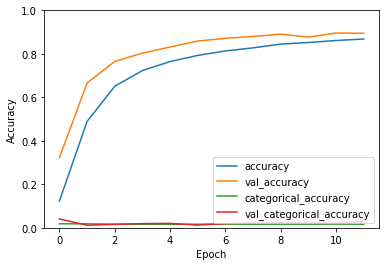

In [127]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'val_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

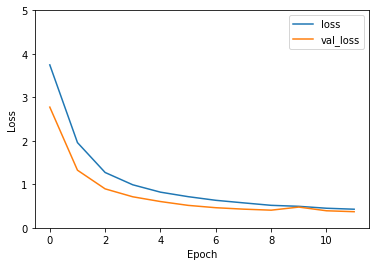

In [128]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='upper right')
plt.show()

In [129]:
test_loss, test_acc, _ = model.evaluate(X_test_, y_test_,  verbose=2)
test_acc

3749/3749 - 1s - loss: 0.3703 - accuracy: 0.8946 - categorical_accuracy: 0.0293


0.8946386

#### Make predictions

In [130]:
pred = model.predict(X_test_)
pred.shape

(3749, 62)

In [131]:
pred_labels = np.asarray([np.argmax(i) for i in pred])

#### Invert labels

In [132]:
y_test_inv = label_enc.inverse_transform(y_test_)
pred_labels_inv = label_enc.inverse_transform(pred_labels)

In [133]:
print(classification_report(y_test_inv, pred_labels_inv))

              precision    recall  f1-score   support

           0       0.50      0.96      0.66        57
           1       0.90      0.90      0.90        41
           2       0.98      0.93      0.95        55
           3       1.00      1.00      1.00        65
           4       0.97      1.00      0.98        64
           5       1.00      0.98      0.99        64
           6       1.00      0.98      0.99        56
           7       0.98      1.00      0.99        59
           8       0.98      1.00      0.99        61
           9       0.98      0.98      0.98        52
           A       0.83      0.89      0.86        70
           B       0.86      0.98      0.91        44
           C       0.81      0.79      0.80        56
           D       0.90      0.92      0.91        62
           E       0.95      0.81      0.87        68
           F       0.84      1.00      0.92        49
           G       0.96      0.82      0.88        61
           H       0.89    

In [134]:
result_df = pd.DataFrame()
result_df['y_test'] = y_test_inv
result_df['predicted'] = pred_labels_inv
result_df

,y_test,predicted
0,X,X
1,p,p
2,l,l
3,G,c
4,p,p
...,...,...
3744,l,l
3745,s,s
3746,r,r
3747,t,t


In [135]:
def check_and_plot(num):
    print(result_df.loc[num])
    imshow(X_test_[num])
    plt.show()

y_test       G
predicted    c
Name: 3, dtype: object


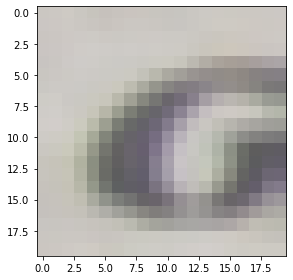

In [136]:
check_and_plot(3)

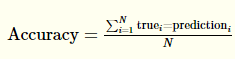

In [137]:
class_accuracy = (result_df['y_test'] == result_df['predicted']).sum() / len(result_df)
class_accuracy

0.8946385702854095

### Extract features

In [138]:
# new_model = Model(inputs = model.input, outputs = model.get_layer('feature_layer').output)

In [139]:
# train_x = new_model.predict(X_train_)

In [140]:
# train_x.shape

(14993, 2, 2, 64)

In [141]:
# train_x_resh = train_x.reshape(train_x.shape[0], 2*2*64)

In [142]:
# train_x_resh.shape

(14993, 256)

In [143]:
# train_x_resh

array([[-0.08564439,  2.355207  , -1.0622369 , ...,  1.7638212 ,
        -0.6215662 ,  0.16698644],
       [-0.32227552, -0.7645089 , -0.49655986, ...,  2.2611923 ,
        -0.6633208 , -0.99258447],
       [ 1.3287126 , -0.14748307, -0.8733938 , ..., -0.89495736,
         0.2331211 ,  1.7826953 ],
       ...,
       [ 1.7524687 , -0.7645089 ,  3.5203767 , ...,  3.9376955 ,
        -0.6633208 , -0.38536114],
       [ 0.11648136, -0.7645089 , -1.0622369 , ..., -0.89495736,
        -0.6633208 , -0.99258447],
       [ 0.5542438 ,  1.1870826 ,  1.2951024 , ..., -0.89495736,
        -0.6633208 , -0.99258447]], dtype=float32)

In [148]:
new_model2 = Model(inputs = model.input, outputs = model.get_layer('feature_layer2').output)   #from flatten layer

In [174]:
#save model
# new_model2.save('feature_extr_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: feature_extr_model\assets


In [9]:
model_test = keras.models.load_model('./feature_extr_model')

In [10]:
model_test.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23_input (InputLayer) [(None, 20, 20, 3)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 20, 20, 20)        560       
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 20, 20)        80        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 20, 20, 20)        3620      
_________________________________________________________________
batch_normalization_16 (Batc (None, 20, 20, 20)        80        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 10, 10, 20)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10, 20)        0   

In [11]:
new_model2 = model_test

In [12]:
train_x_compr = new_model2.predict(X_train_)
test_x_compr = new_model2.predict(X_test_)

print(train_x_compr.shape, test_x_compr.shape)

(14993, 256) (3749, 256)


In [13]:
# np.savez('extracted_imgs', train_x_compr = train_x_compr, test_x_compr = test_x_compr)

In [14]:
extracted_imgs = np.load('extracted_imgs.npz')
extracted_imgs.files

['train_x_compr', 'test_x_compr']

In [15]:
train_x_compr = extracted_imgs[extracted_imgs.files[0]]
test_x_compr = extracted_imgs[extracted_imgs.files[1]]

print(train_x_compr.shape, test_x_compr.shape)

(14993, 256) (3749, 256)


### SVM

In [34]:
%%time

# linear = SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(train_x_compr, y_train_)

# rbf = SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(train_x_compr, y_train_)

poly = SVC(kernel='poly', degree=2, C=1000, decision_function_shape='ovo').fit(train_x_compr, y_train_)

# sig = SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(train_x_compr, y_train_)

Wall time: 14.3 s


In [35]:
# linear_pred = linear.predict(test_x_compr)

poly_pred = poly.predict(test_x_compr)

# rbf_pred = rbf.predict(test_x_compr)

# sig_pred = sig.predict(test_x_compr)

In [36]:
# retrieve the accuracy and print it for all 4 kernel functions
# # accuracy_lin = linear.score(test_x_compr, y_test_)
accuracy_poly = poly.score(test_x_compr, y_test_)
# # accuracy_rbf = rbf.score(test_x_compr, y_test_)
# # accuracy_sig = sig.score(test_x_compr, y_test_)

# print('Accuracy Linear Kernel:', accuracy_lin)
print('Accuracy Polynomial Kernel:', accuracy_poly)
# print('Accuracy Radial Basis Kernel:', accuracy_rbf)
# print('Accuracy Sigmoid Kernel:', accuracy_sig)

Accuracy Polynomial Kernel: 0.9423846359029074


In [157]:
linear_pred

array([33, 51, 47, ..., 53, 55, 32])

In [20]:
y_test_inv = label_enc.inverse_transform(y_test_)
linear_pred_inv = label_enc.inverse_transform(linear_pred)

In [21]:
print(classification_report(y_test_inv, linear_pred_inv))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83        57
           1       0.90      0.93      0.92        41
           2       0.95      0.98      0.96        55
           3       0.97      1.00      0.98        65
           4       1.00      1.00      1.00        64
           5       0.97      1.00      0.98        64
           6       1.00      1.00      1.00        56
           7       1.00      1.00      1.00        59
           8       1.00      1.00      1.00        61
           9       1.00      1.00      1.00        52
           A       0.91      0.90      0.91        70
           B       0.83      0.98      0.90        44
           C       0.91      0.86      0.88        56
           D       0.97      0.95      0.96        62
           E       0.87      0.88      0.88        68
           F       0.92      1.00      0.96        49
           G       0.93      0.90      0.92        61
           H       0.85    

In [22]:
result_df_svc = pd.DataFrame()
result_df_svc['y_test'] = y_test_inv
result_df_svc['predicted'] = linear_pred_inv
result_df_svc

,y_test,predicted
0,X,X
1,p,p
2,l,l
3,G,C
4,p,p
...,...,...
3744,l,l
3745,s,S
3746,r,r
3747,t,t


In [23]:
class_accuracy_svc = (result_df_svc['y_test'] == result_df_svc['predicted']).sum() / len(result_df_svc)
class_accuracy_svc

0.9327820752200587

#### Grid search

In [23]:
parameters = [
  {'C': [0.1, 1, 10], 'kernel': ['linear']},
  {'C': [0.1, 1, 10], 'gamma': [0.01, 1, 10], 'kernel': ['rbf']},
    {'C': [0.1, 1, 10], 'degree': [1, 2, 3], 'kernel': ['poly']},
    {'C': [0.1, 1, 10], 'gamma': [0.01, 1, 10], 'kernel': ['sigmoid']}
 ]

In [24]:
linear_grid = SVC()
clf = GridSearchCV(linear_grid, parameters, scoring='accuracy', verbose=10)
clf.fit(train_x_compr, y_train_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START C=0.1, kernel=linear.......................................
[CV 1/5; 1/30] END ........C=0.1, kernel=linear;, score=0.944 total time=  12.4s
[CV 2/5; 1/30] START C=0.1, kernel=linear.......................................
[CV 2/5; 1/30] END ........C=0.1, kernel=linear;, score=0.940 total time=  12.7s
[CV 3/5; 1/30] START C=0.1, kernel=linear.......................................
[CV 3/5; 1/30] END ........C=0.1, kernel=linear;, score=0.947 total time=  12.0s
[CV 4/5; 1/30] START C=0.1, kernel=linear.......................................
[CV 4/5; 1/30] END ........C=0.1, kernel=linear;, score=0.936 total time=  11.9s
[CV 5/5; 1/30] START C=0.1, kernel=linear.......................................
[CV 5/5; 1/30] END ........C=0.1, kernel=linear;, score=0.944 total time=  11.9s
[CV 1/5; 2/30] START C=1, kernel=linear.........................................
[CV 1/5; 2/30] END ..........C=1, kernel=linear

[CV 1/5; 11/30] END ..C=10, gamma=1, kernel=rbf;, score=0.432 total time= 1.3min
[CV 2/5; 11/30] START C=10, gamma=1, kernel=rbf.................................
[CV 2/5; 11/30] END ..C=10, gamma=1, kernel=rbf;, score=0.430 total time= 1.3min
[CV 3/5; 11/30] START C=10, gamma=1, kernel=rbf.................................
[CV 3/5; 11/30] END ..C=10, gamma=1, kernel=rbf;, score=0.425 total time= 1.3min
[CV 4/5; 11/30] START C=10, gamma=1, kernel=rbf.................................
[CV 4/5; 11/30] END ..C=10, gamma=1, kernel=rbf;, score=0.434 total time= 1.3min
[CV 5/5; 11/30] START C=10, gamma=1, kernel=rbf.................................
[CV 5/5; 11/30] END ..C=10, gamma=1, kernel=rbf;, score=0.430 total time= 1.3min
[CV 1/5; 12/30] START C=10, gamma=10, kernel=rbf................................
[CV 1/5; 12/30] END .C=10, gamma=10, kernel=rbf;, score=0.405 total time= 1.2min
[CV 2/5; 12/30] START C=10, gamma=10, kernel=rbf................................
[CV 2/5; 12/30] END .C=10, g

[CV 2/5; 21/30] END C=10, degree=3, kernel=poly;, score=0.940 total time=  18.7s
[CV 3/5; 21/30] START C=10, degree=3, kernel=poly...............................
[CV 3/5; 21/30] END C=10, degree=3, kernel=poly;, score=0.942 total time=  18.7s
[CV 4/5; 21/30] START C=10, degree=3, kernel=poly...............................
[CV 4/5; 21/30] END C=10, degree=3, kernel=poly;, score=0.937 total time=  18.5s
[CV 5/5; 21/30] START C=10, degree=3, kernel=poly...............................
[CV 5/5; 21/30] END C=10, degree=3, kernel=poly;, score=0.943 total time=  18.1s
[CV 1/5; 22/30] START C=0.1, gamma=0.01, kernel=sigmoid.........................
[CV 1/5; 22/30] END C=0.1, gamma=0.01, kernel=sigmoid;, score=0.441 total time=  37.4s
[CV 2/5; 22/30] START C=0.1, gamma=0.01, kernel=sigmoid.........................
[CV 2/5; 22/30] END C=0.1, gamma=0.01, kernel=sigmoid;, score=0.464 total time=  36.7s
[CV 3/5; 22/30] START C=0.1, gamma=0.01, kernel=sigmoid.........................
[CV 3/5; 22/30] 

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'gamma': [0.01, 1, 10],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10], 'degree': [1, 2, 3],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 10], 'gamma': [0.01, 1, 10],
                          'kernel': ['sigmoid']}],
             scoring='accuracy', verbose=10)

In [25]:
clf.best_estimator_

SVC(C=10, degree=2, kernel='poly')

In [26]:
clf.best_score_

0.948642676311272

In [27]:
clf.best_params_

{'C': 10, 'degree': 2, 'kernel': 'poly'}

### Cross valid

In [52]:
linear_model_kfold = SVC(kernel='linear', C=1, decision_function_shape='ovo')

In [53]:
k_fold = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)

In [54]:
train_acc_arr = []
coun = 1
for k_train_index, k_val_index in k_fold.split(train_x_compr, y_train_):
    print(f'Fold {coun}')
    
    linear_model_kfold.fit(train_x_compr[k_train_index,:], y_train_[k_train_index])
    
    train_acc = linear_model_kfold.score(train_x_compr, y_train_)
    train_acc_arr.append(train_acc)
    
    print('-------------')
    coun +=1

Fold 1
-------------
Fold 2
-------------
Fold 3
-------------
Fold 4
-------------
Fold 5
-------------


### KNN

In [102]:
num_classes = len(np.unique(y_train_))
knn_model = KNeighborsClassifier(n_neighbors=num_classes, weights='distance', algorithm='kd_tree', n_jobs=-1)

In [103]:
knn_model.fit(train_x_compr, y_train_)

KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=62,
                     weights='distance')

In [104]:
knn_predict= knn_model.predict(test_x_compr)

In [105]:
knn_predict

array([33, 51, 47, ..., 53, 55, 32])

In [106]:
knn_model.score(test_x_compr, y_test_)

0.8591624433182182

### Prepare data for submission

In [24]:
def get_imnames():
    txtfiles = []
    for file in glob.glob(TEST_IMG_PATH + "*.Bmp"):
        file = file.split('\\')[-1][:-4] #get only filename
        txtfiles.append(file)
        
    return txtfiles

txtfiles = get_imnames()
len(txtfiles)

6220

In [25]:
presub_df = pd.DataFrame()
presub_df['id'] = txtfiles
presub_df['id'] = pd.to_numeric(presub_df['id'])
presub_df['img'] = [TEST_IMG_PATH + str(id_) + '.Bmp' for id_ in presub_df['id'].values]
presub_df.sort_values(by=['id'], inplace=True)
presub_df.reset_index(inplace=True, drop=True)

In [26]:
presub_df

,id,img
0,6284,./data/street-view-getting-started-with-julia/...
1,6285,./data/street-view-getting-started-with-julia/...
2,6286,./data/street-view-getting-started-with-julia/...
3,6287,./data/street-view-getting-started-with-julia/...
4,6288,./data/street-view-getting-started-with-julia/...
...,...,...
6215,12499,./data/street-view-getting-started-with-julia/...
6216,12500,./data/street-view-getting-started-with-julia/...
6217,12501,./data/street-view-getting-started-with-julia/...
6218,12502,./data/street-view-getting-started-with-julia/...


#### Check grey imgs

In [27]:
grey_imgs = check_grey_imgs(presub_df[['img']])
grey_imgs

[]

In [28]:
X_sub = np.asarray([transform_image(i).tolist() for i in presub_df['img'].values])
X_sub.shape

(6220, 20, 20, 3)

### Extract features from X_sub

In [31]:
X_sub_compr = new_model2.predict(X_sub)
X_sub_compr.shape

(6220, 256)

### Make prediction

In [38]:
linear_sub_pred = linear.predict(X_sub_compr)

In [39]:
linear_sub_pred

array([17, 14, 18, ..., 27, 23, 22])

In [40]:
sub_labels_inv = label_enc.inverse_transform(linear_sub_pred)

In [41]:
sub_labels_inv

array(['H', 'E', 'I', ..., 'R', 'N', 'M'], dtype=object)

### Make prediction kfold

In [55]:
linear_kfold_sub_pred = linear_model_kfold.predict(X_sub_compr)
linear_kfold_sub_pred

array([17, 14, 18, ..., 27, 23, 22])

In [56]:
kfold_sub_labels_inv = label_enc.inverse_transform(linear_kfold_sub_pred)
kfold_sub_labels_inv

array(['H', 'E', 'I', ..., 'R', 'N', 'M'], dtype=object)

### Create submission file

In [57]:
sub_df = pd.DataFrame()
sub_df['ID'] = presub_df['id']
sub_df['Class'] = kfold_sub_labels_inv
sub_df.set_index('ID', inplace=True)
sub_df

,Class
ID,
6284,H
6285,E
6286,I
6287,d
6288,T
...,...
12499,0
12500,o
12501,R


In [58]:
sub_df.to_csv('submission_cnn_svc.csv')